In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os 
os.chdir(f"{os.getenv('HOME')}/r1_hackathon")

In [2]:
### Load the data
data_dir = "./outputs"
base_df = pd.DataFrame()
for run in [1,2,3,4,5]:
    df = pd.read_csv(f"{data_dir}/run{run}.csv")
    df["run"] = [run]*len(df)
    base_df = pd.concat([base_df, df])

data = base_df.copy()
data = data.rename(columns={"Unnamed: 0": "id"}) # Hacky way of coding in ID

In [3]:
### Add extracted thoughts and answers:
# A regex to extract text between a <THINK> and </THINK> tag:
def extract_think(text):
    try:
        return re.search(r'<think>([\s\S]*?)<\/think>', text).group(0)
    except AttributeError:
        return ""

# A regex to extract all other text (not in a <THINK>, and excluding the tags themselves):
def extract_answer(text):
    return re.sub(r'<think>([\s\S]*?)<\/think>', "", text) 

data['gp_thought'] = data['gp_response'].apply(extract_think)
data['gp_answer'] = data['gp_response'].apply(extract_answer)
data['non_gp_thought'] = data['non_gp_response'].apply(extract_think)
data['non_gp_answer'] = data['non_gp_response'].apply(extract_answer)

In [19]:
### Add lengths in words:
data['gp_thought_len'] = data['gp_thought'].apply(lambda x: len(x.split()))
data['gp_answer_len'] = data['gp_answer'].apply(lambda x: len(x.split()))
data['non_gp_thought_len'] = data['non_gp_thought'].apply(lambda x: len(x.split()))
data['non_gp_answer_len'] = data['non_gp_answer'].apply(lambda x: len(x.split()))
data['thought_len_diff'] = data['gp_thought_len'] - data['non_gp_thought_len']


In [5]:
### Adding keyword counts:
keywords = ["wait", "recheck", "alternatively", "retry", "however"] # First stab

# Return a dictionary of keyword counts:
data['gp_thought_keywords'] = data['gp_thought'].apply(lambda x: {k: x.lower().count(k) for k in keywords})
data['gp_answer_keywords'] = data['gp_answer'].apply(lambda x: {k: x.lower().count(k) for k in keywords})
data['non_gp_thought_keywords'] = data['non_gp_thought'].apply(lambda x: {k: x.lower().count(k) for k in keywords})
data['non_gp_answer_keywords'] = data['non_gp_answer'].apply(lambda x: {k: x.lower().count(k) for k in keywords})
data['gp_thought_keyword_count'] = data['gp_thought_keywords'].apply(lambda x: sum(x.values()))
data['gp_answer_keyword_count'] = data['gp_answer_keywords'].apply(lambda x: sum(x.values()))
data['non_gp_thought_keyword_count'] = data['non_gp_thought_keywords'].apply(lambda x: sum(x.values()))
data['non_gp_answer_keyword_count'] = data['non_gp_answer_keywords'].apply(lambda x: sum(x.values()))

In [6]:
### Look at a sample:
index = 0
sample = data.iloc[index]

for column in sample.index:
    print(f"{column}: {sample[column]}")
    print("\n")


id: 0


gp_sentence: While the secretary typed the memo neared completion.


non_gp_sentence: The memo neared completion while the secretary typed.


question: Is it true that the secretary typed the memo?


semantic_plausibility: 1


gp_response: <think>
Okay, let's take a look at this sentence: "While the secretary typed the memo neared completion." The user is asking if it's true that the secretary typed the memo. Hmm, the sentence structure here is a bit confusing. Let me break it down.

First, "While the secretary typed the memo" is a dependent clause. Then we have "neared completion." Wait, that doesn't seem right. The main clause should have a subject and a verb. The way it's written now, "neared completion" is the main verb, but what's the subject? It seems like the sentence is trying to say that while the secretary was typing the memo, something else was nearing completion. But the way it's structured, it's unclear. Maybe there's a missing subject in the main clause. For examp

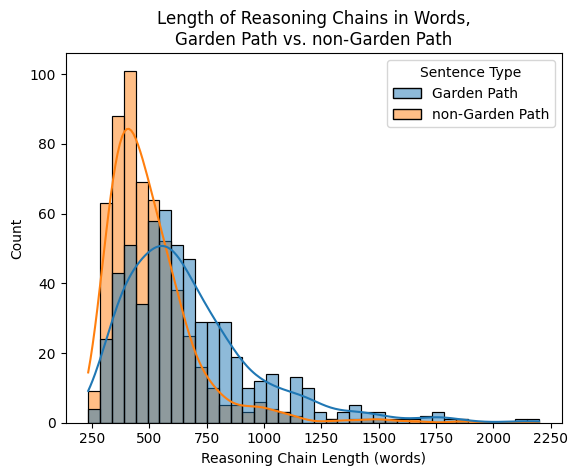

In [33]:
### Make some plots:
# Plot the distribution of thought lengths, split by GP/non-GP:

# Transform data using pd.melt, so that each row only has one type (GP/non-GP):
id_vars = [col for col in data.columns if col not in ['gp_thought_len', 'non_gp_thought_len']]
data_melted = pd.melt(data, id_vars=id_vars, value_vars=['gp_thought_len', 'non_gp_thought_len'], var_name='Sentence Type', value_name='thought_len')
sns.histplot(data=data_melted, x='thought_len', hue='Sentence Type', kde=True)
# Add labels: 
# 'type': 'Sentence Type'
# 'gp_thought_len': 'Garden Path'
# 'non_gp_thought_len': 'non-Garden Path'
plt.xlabel("Reasoning Chain Length (words)")
plt.ylabel("Count")
plt.title("Length of Reasoning Chains in Words,\nGarden Path vs. non-Garden Path")

# Change legend labels
legend_labels = {'gp_thought_len': 'Garden Path', 'non_gp_thought_len': 'non-Garden Path'}
for t in plt.gca().get_legend().texts:
    t.set_text(legend_labels[t.get_text()])

plt.show()

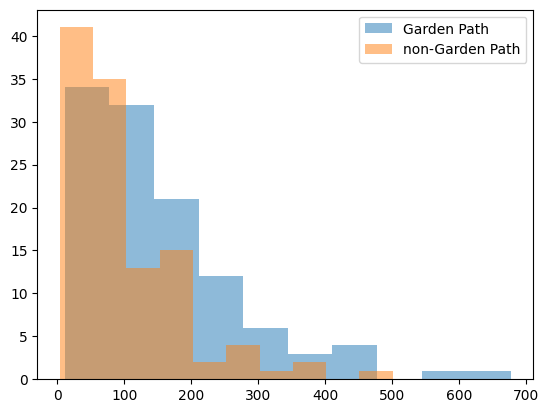

In [8]:
### Variance of thought lengths:
# Calculate the standard deviation of thought lengths for each datapoint:
gp_thought_vars = []
non_gp_thought_vars = []
for id in np.unique(data['id']):
    indexed = data[data['id'] == id]
    gp_thought_var = np.std(indexed['gp_thought_len'])
    non_gp_thought_var = np.std(indexed['non_gp_thought_len'])
    gp_thought_vars.append(gp_thought_var)
    non_gp_thought_vars.append(non_gp_thought_var)

# Plot the variance of thought lengths:
plt.hist(gp_thought_vars, alpha=0.5, label='Garden Path')
plt.hist(non_gp_thought_vars, alpha=0.5, label='non-Garden Path')
plt.legend()


In [9]:

### Look at super long ones:
high_gp_length = data[data['gp_thought_len'] > 800]

# Look at samples:
for i, row in high_gp_length.iterrows():
    print(f"Index: {i}")
    print(f"GP Sentence + Question: {row['gp_sentence']}. {row['question']}")
    print(f"GP Thought Length: {row['gp_thought_len']}")
    print(f"GP Thought: {row['gp_thought']}")
    print(f"GP Answer: {row['gp_answer']}")
    print("\n")


Index: 4
GP Sentence + Question: While the cowboy rode the horse sweated profusely.. Is it true that the cowboy rode the horse?
GP Thought Length: 946
GP Thought: <think>
Okay, let's see. The sentence is "While the cowboy rode the horse sweated profusely." The question is asking if it's true that the cowboy rode the horse. Hmm.

First, I need to parse the sentence structure. The original sentence is a bit ambiguous because of the way it's written. The main issue here is the lack of punctuation, which can lead to different interpretations. Let me break it down.

The sentence starts with "While the cowboy rode the horse..." So, "while" introduces a dependent clause. The structure is "While [something happened], [something else happened]." But in this case, the sentence continues as "...sweated profusely." Wait, that doesn't seem right. The dependent clause is "While the cowboy rode the horse," and then the main clause should follow. But the way it's written, "the horse sweated profusely"

<Axes: xlabel='keyword_count', ylabel='Count'>

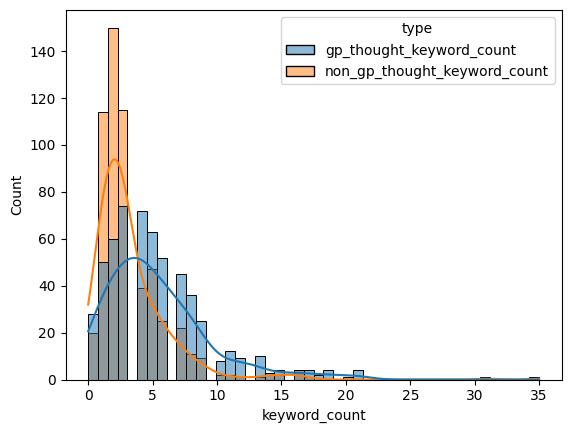

In [10]:
data_melted = pd.melt(data, value_vars=['gp_thought_keyword_count', 'non_gp_thought_keyword_count'], var_name='type', value_name='keyword_count')
sns.histplot(data=data_melted, x='keyword_count', hue='type', kde=True)


Text(0.5, 1.0, "'Thought' Lengths for Garden Path vs.\nNon-Garden Path Prompts")

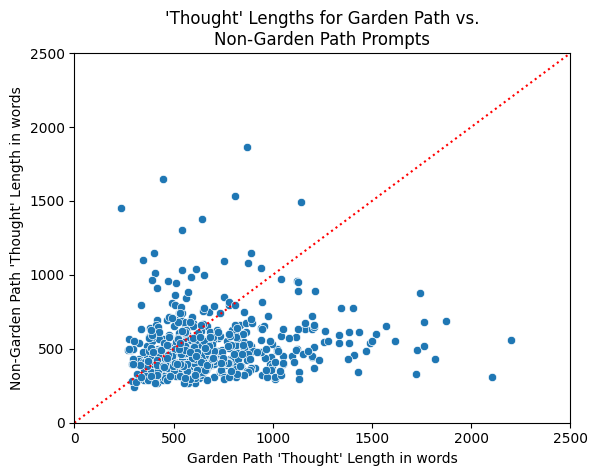

In [11]:
sns.scatterplot(data=data, x='gp_thought_len', y='non_gp_thought_len')
plt.xlim((0,2500))
plt.ylim((0,2500))
# Overlay dotted y=x line:
plt.plot([0, 2500], [0, 2500], color='red', linestyle='dotted')

plt.xlabel("Garden Path 'Thought' Length in words")
plt.ylabel("Non-Garden Path 'Thought' Length in words")

plt.title("'Thought' Lengths for Garden Path vs.\nNon-Garden Path Prompts")

Text(0.5, 1.0, 'Difference in Reasoning Chain Lengths for Garden Path vs.\nNon-Garden Path Prompts')

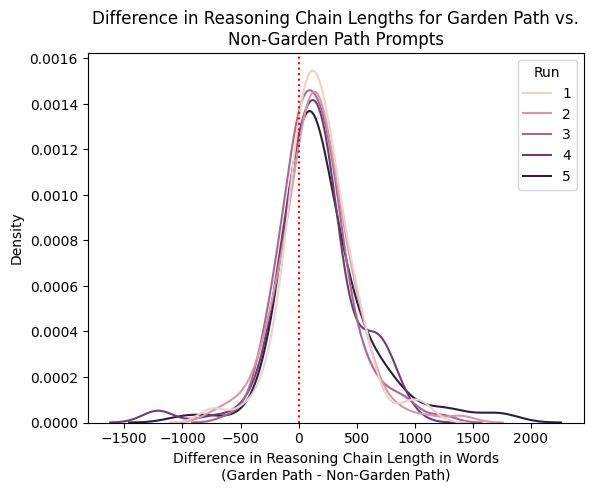

In [31]:
data = data.rename(columns={"run": "Run"})
sns.kdeplot(data=data, x='thought_len_diff', hue='Run', fill=False, common_norm=False)
# Add a vertical line at 0:
plt.axvline(0, color='red', linestyle='dotted')
plt.xlabel("Difference in Reasoning Chain Length in Words\n(Garden Path - Non-Garden Path)")
plt.ylabel("Density")
plt.title("Difference in Reasoning Chain Lengths for Garden Path vs.\nNon-Garden Path Prompts")

In [13]:
### Aggregate data across runs:
# Basically do this, but also add columns for std: data.groupby('id').agg({'gp_thought_len': 'mean', 'non_gp_thought_len': 'mean'})
data_agg = data.groupby('id').agg({'gp_thought_len': ['mean', 'std'], 'non_gp_thought_len': ['mean', 'std']})
data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns.values]
data_agg

,gp_thought_len_mean,gp_thought_len_std,non_gp_thought_len_mean,non_gp_thought_len_std
id,,,,
0,472.8,101.659727,507.2,160.301903
1,345.0,56.811090,401.4,171.184988
2,471.2,68.863633,578.8,142.213572
3,609.8,74.052009,460.8,172.045633
4,821.2,186.825319,415.6,213.930596
...,...,...,...,...
109,740.2,340.611509,499.0,58.604607
110,813.0,199.468043,578.6,179.667192
111,942.0,356.948176,527.6,31.500794


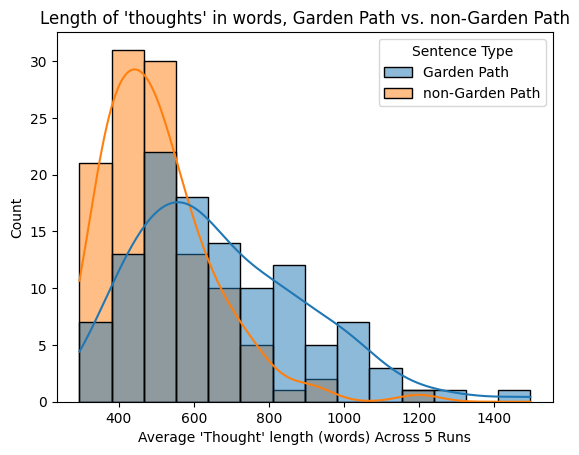

In [14]:
# Transform data using pd.melt, so that each row only has one type (GP/non-GP):
data_melted = pd.melt(data_agg, value_vars=['gp_thought_len_mean', 'non_gp_thought_len_mean'], var_name='Sentence Type', value_name='thought_len_mean')
sns.histplot(data=data_melted, x='thought_len_mean', hue='Sentence Type', kde=True)
# Add labels: 
# 'type': 'Sentence Type'
# 'gp_thought_len': 'Garden Path'
# 'non_gp_thought_len': 'non-Garden Path'
plt.xlabel("Average 'Thought' length (words) Across 5 Runs")
plt.ylabel("Count")
plt.title("Length of 'thoughts' in words, Garden Path vs. non-Garden Path")

# Change legend labels
legend_labels = {'gp_thought_len_mean': 'Garden Path', 'non_gp_thought_len_mean': 'non-Garden Path'}
for t in plt.gca().get_legend().texts:
    t.set_text(legend_labels[t.get_text()])

plt.show()

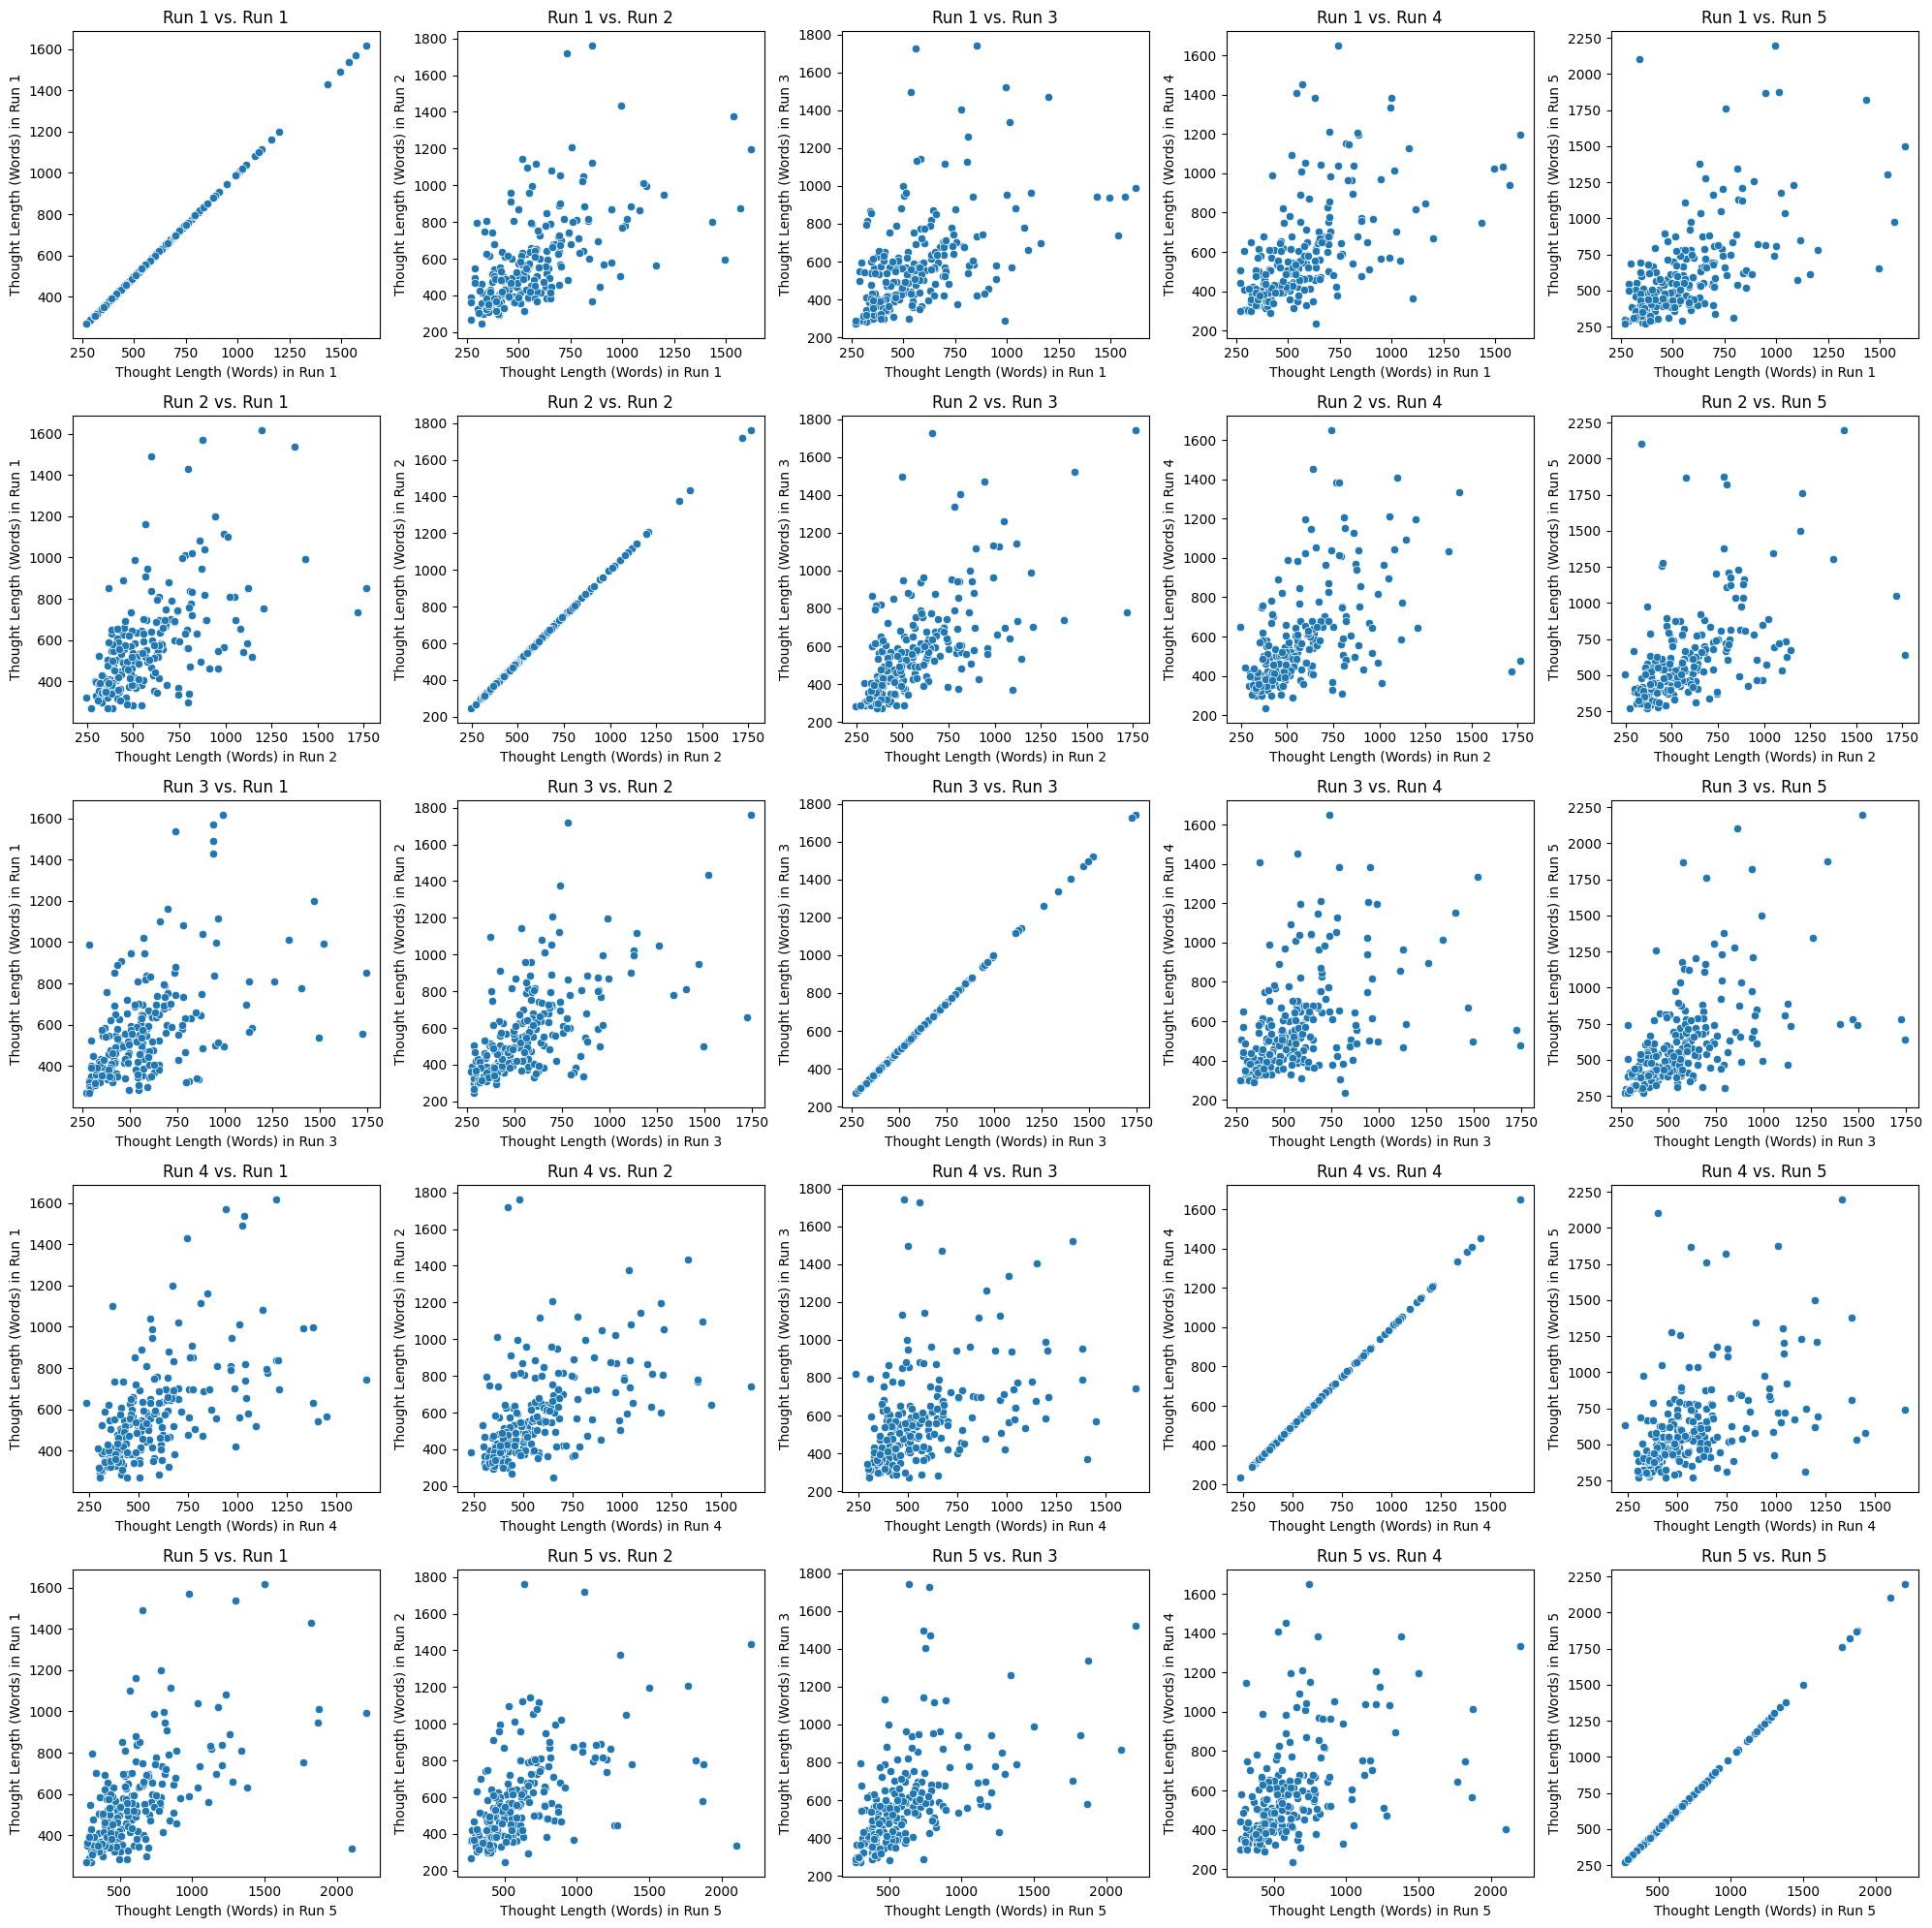

In [34]:
runwise_dfs = {}
for run in [1,2,3,4,5]:
    runwise_df = data[data['run'] == run]
    # Now, melt the data, so that each row only has one type (GP/non-GP):
    id_vars = [col for col in runwise_df.columns if col not in ['gp_thought_len', 'non_gp_thought_len']]
    runwise_melted = pd.melt(runwise_df, id_vars=id_vars, value_vars=['gp_thought_len', 'non_gp_thought_len'], var_name='Sentence Type', value_name='thought_len')
    runwise_dfs[run] = runwise_melted


# Now create a grid of plots:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for x, run_x in enumerate([1,2,3,4,5]):
    for y, run_y in enumerate([1,2,3,4,5]):
        sns.scatterplot(x=runwise_dfs[run_x]['thought_len'], y=runwise_dfs[run_y]['thought_len'], ax=axs[x, y])
        axs[x, y].set_title(f"Run {run_x} vs. Run {run_y}")
        axs[x, y].set_xlabel(f"Thought Length (Words) in Run {run_x}")
        axs[x, y].set_ylabel(f"Thought Length (Words) in Run {run_y}")
        # Change legend labels
        legend_labels = {'gp_thought_len': 'Garden Path', 'non_gp_thought_len': 'non-Garden Path'}

plt.tight_layout()
plt.show()

In [28]:
# Calculate bootstrapped C.I.s of difference in thought lengths, within each run:
from scipy.stats import bootstrap
import random

for run in [1,2,3,4,5]:
    run_df = data[data['Run'] == run]
    thought_len_difference_bCIs = bootstrap((run_df['thought_len_diff'],), np.mean, confidence_level=0.95, n_resamples=10000, method='percentile', random_state=3535)
    print(f"Run {run}: Mean difference in thought lengths: {np.mean(run_df['thought_len_diff'])}")
    print(f"Run {run}: 95% C.I. of difference in thought lengths: {thought_len_difference_bCIs.confidence_interval}")
    print("\n")




Run 1: Mean difference in thought lengths: 172.19298245614036
Run 1: 95% C.I. of difference in thought lengths: ConfidenceInterval(low=np.float64(119.39429824561404), high=np.float64(226.43092105263156))


Run 2: Mean difference in thought lengths: 151.76315789473685
Run 2: 95% C.I. of difference in thought lengths: ConfidenceInterval(low=np.float64(94.62061403508774), high=np.float64(209.09846491228066))


Run 3: Mean difference in thought lengths: 151.859649122807
Run 3: 95% C.I. of difference in thought lengths: ConfidenceInterval(low=np.float64(99.49934210526317), high=np.float64(206.61513157894734))


Run 4: Mean difference in thought lengths: 147.16666666666666
Run 4: 95% C.I. of difference in thought lengths: ConfidenceInterval(low=np.float64(83.28026315789474), high=np.float64(209.90526315789472))


Run 5: Mean difference in thought lengths: 222.82456140350877
Run 5: 95% C.I. of difference in thought lengths: ConfidenceInterval(low=np.float64(152.12258771929825), high=np.float6